<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/Probabilistic_deep_learning_TensorFlow2/TensorFlow_distributions/Multivariate_Gaussian_full_covariance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Gaussian with full covariance

In this reading you will learn how you can use TensorFlow to specify any multivariate Gaussian distribution.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.8.0
TFP version: 0.16.0


So far, you've seen how to define multivariate Gaussian distributions using `tfd.MultivariateNormalDiag`. This class allows you to specify a multivariate Gaussian with a diagonal covariance matrix $\Sigma$. 

In cases where the variance is the same for each component, i.e. $\Sigma = \sigma^2 I$, this is known as a _spherical_ or _isotropic_ Gaussian. This name comes from the spherical (or circular) contours of its probability density function, as you can see from the plot below for the two-dimensional case. 

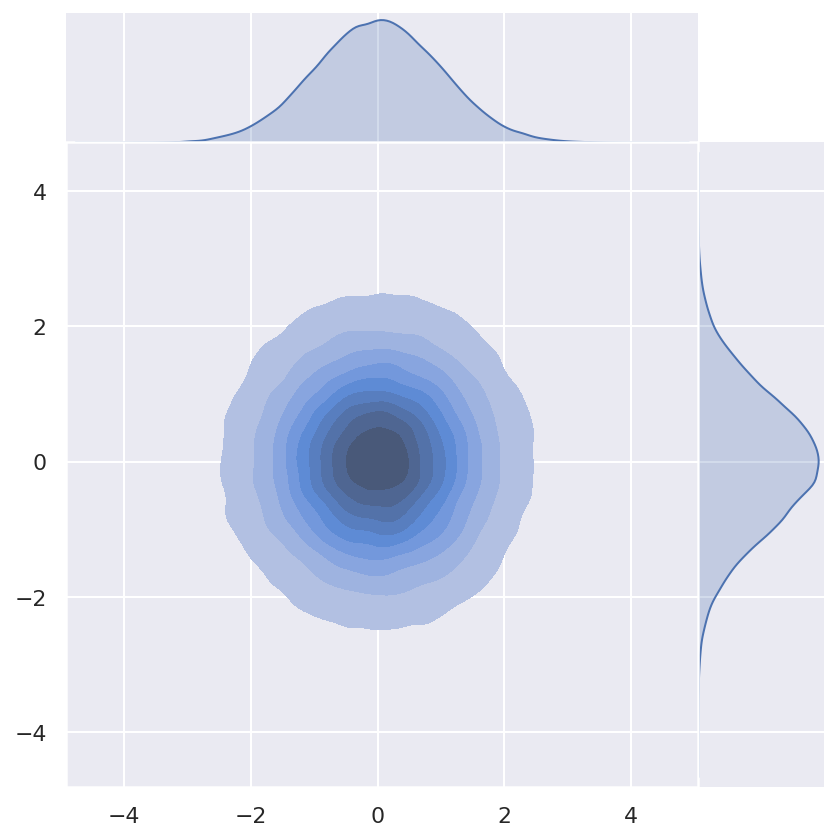

In [2]:
# Plot the approximate density contours of a 2d spherical Gaussian

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

tf.random.set_seed(123)

spherical_2d_gaussian = tfd.MultivariateNormalDiag(loc=[0., 0.])

N = 100000
x = spherical_2d_gaussian.sample(N)
x1 = x[:, 0]
x2 = x[:, 1]
sns.jointplot(x=x1, y=x2, kind='kde', space=0, fill=True);

As you know, a diagonal covariance matrix results in the components of the random vector being independent. 

## Full covariance with `MultivariateNormalFullTriL`

You can define a full covariance Gaussian distribution in TensorFlow using the Distribution `tfd.MultivariateNormalTriL`.

Mathematically, the parameters of a multivariate Gaussian are a mean $\mu$ and a covariance matrix $\Sigma$, and so the `tfd.MultivariateNormalTriL` constructor requires two arguments:

- `loc`, a Tensor of floats corresponding to $\mu$,
- `scale_tril`, a a lower-triangular matrix $L$ such that $LL^T = \Sigma$.

For a $d$-dimensional random variable, the lower-triangular matrix $L$ looks like this:

\begin{equation}
    L = \begin{bmatrix}
            l_{1, 1} & 0 & 0 & \cdots & 0 \\
            l_{2, 1} & l_{2, 2} & 0 & \cdots & 0  \\
            l_{3, 1} & l_{3, 2} & l_{3, 3} & \cdots & 0  \\
            \vdots  & \vdots & \vdots & \ddots & \vdots \\
            l_{d, 1} & l_{d, 2} & l_{d, 3} & \cdots & l_{d, d}
        \end{bmatrix},
\end{equation}

where the diagonal entries are positive: $l_{i, i} > 0$ for $i=1,\ldots,d$.

Here is an example of creating a two-dimensional Gaussian with non-diagonal covariance:

In [3]:
# Set the mean and covariance parameters

mu = [0., 0.]  # mean
scale_tril = [[1.,  0.],
              [0.6, 0.8]]

sigma = tf.matmul(tf.constant(scale_tril), 
    tf.transpose(tf.constant(scale_tril)))  # covariance matrix
print(sigma)

tf.Tensor(
[[1.  0.6]
 [0.6 1. ]], shape=(2, 2), dtype=float32)


In [4]:
# Create the 2D Gaussian with full covariance

nonspherical_2d_gaussian = tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril)
nonspherical_2d_gaussian

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

In [5]:
# Check the Distribution mean

nonspherical_2d_gaussian.mean()

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [6]:
# Check the Distribution covariance

nonspherical_2d_gaussian.covariance()

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1. , 0.6],
       [0.6, 1. ]], dtype=float32)>

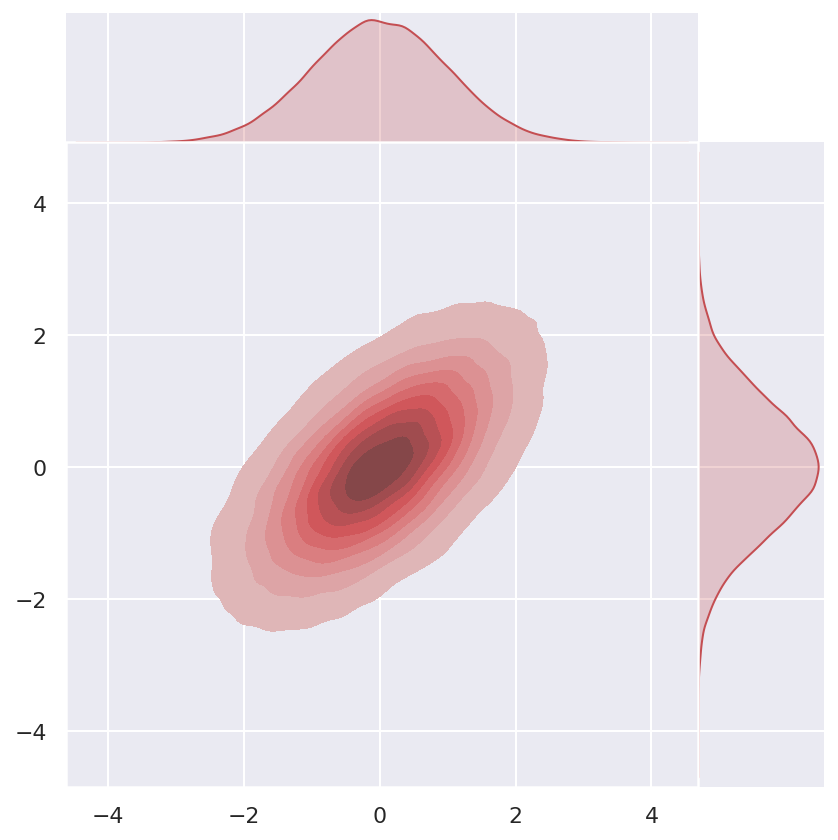

In [7]:
# Plot its approximate density contours

x = nonspherical_2d_gaussian.sample(N)
x1 = x[:, 0]
x2 = x[:, 1]
sns.jointplot(x=x1, y=x2, kind='kde', space=0, color='r', fill=True);

As you can see, the approximate density contours are now elliptical rather than circular. This is because the components of the Gaussian are correlated.

Also note that the marginal distributions (shown on the sides of the plot) are both univariate Gaussian distributions.

## The Cholesky decomposition

In the above example, we defined the lower triangular matrix $L$ and used that to build the multivariate Gaussian distribution. The covariance matrix is easily computed from $L$ as $\Sigma = LL^T$.

The reason that we define the multivariate Gaussian distribution in this way - as opposed to directly passing in the covariance matrix - is that not every matrix is a valid covariance matrix. The covariance matrix must have the following properties:

1. It is symmetric
2. It is positive (semi-)definite

_NB: A symmetric matrix $M \in \mathbb{R}^{d\times d}$ is positive semi-definite if it satisfies $b^TMb \ge 0$ for all nonzero $b\in\mathbb{R}^d$. If, in addition, we have $b^TMb = 0 \Rightarrow b=0$ then $M$ is positive definite._

The Cholesky decomposition is a useful way of writing a covariance matrix. The decomposition is described by this result:

> For every real-valued symmetric positive-definite matrix $M$, there is a unique lower-diagonal matrix $L$ that has  positive diagonal entries for which  
>
> \begin{equation}
     LL^T = M
 \end{equation}
> This is called the _Cholesky decomposition_ of $M$.

This result shows us why Gaussian distributions with full covariance are completely represented by the `MultivariateNormalTriL` Distribution.

### `tf.linalg.cholesky`

In case you have a valid covariance matrix $\Sigma$ and would like to compute the lower triangular matrix $L$ above to instantiate a `MultivariateNormalTriL` object, this can be done with the `tf.linalg.cholesky` function. 

In [ ]:
# Define a symmetric positive-definite matrix

sigma = [[10., 5.], [5., 10.]]
sigma

[[10.0, 5.0], [5.0, 10.0]]

In [ ]:
# Compute the lower triangular matrix L from the Cholesky decomposition

scale_tril = tf.linalg.cholesky(sigma)
scale_tril

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3.1622777, 0.       ],
       [1.5811388, 2.7386127]], dtype=float32)>

In [ ]:
# Check that LL^T = Sigma

tf.linalg.matmul(scale_tril, tf.transpose(scale_tril))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[10.      ,  5.      ],
       [ 5.      ,  9.999999]], dtype=float32)>

If the argument to the `tf.linalg.cholesky` is not positive definite, then it will fail:

In [ ]:
# Try to compute the Cholesky decomposition for a matrix with negative eigenvalues

bad_sigma = [[10., 11.], [11., 10.]]

try:
    scale_tril = tf.linalg.cholesky(bad_sigma)
except Exception as e:
    print(e)

Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]


### What about positive semi-definite matrices?

In cases where the matrix is only positive semi-definite, the Cholesky decomposition exists (if the diagonal entries of $L$ can be zero) but it is not unique.

For covariance matrices, this corresponds to the degenerate case where the probability density function collapses to a subspace of the event space. This is demonstrated in the following example:

In [ ]:
# Create a multivariate Gaussian with a positive semi-definite covariance matrix

psd_mvn = tfd.MultivariateNormalTriL(
    loc=[0., 0.], scale_tril=[[1., 0.], [0.4, 0.]])
psd_mvn

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

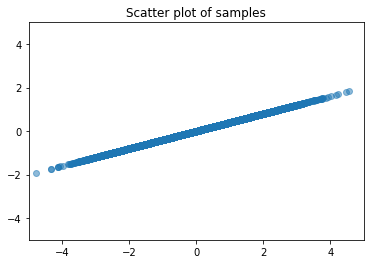

In [ ]:
# Plot samples from this distribution

x = psd_mvn.sample(N)
x1 = x[:, 0]
x2 = x[:, 1]
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Scatter plot of samples")
plt.scatter(x1, x2, alpha=0.5);

If the input to the function `tf.linalg.cholesky` is positive semi-definite but not positive definite, it will also fail:

In [ ]:
# Try to compute the Cholesky decomposition for a positive semi-definite matrix

another_bad_sigma = [[10., 0.], [0., 0.]]

try:
    scale_tril = tf.linalg.cholesky(another_bad_sigma)
except Exception as e:
    print(e)

Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]


In summary: if the covariance matrix $\Sigma$ for your multivariate Gaussian distribution is positive-definite, then an algorithm that computes the Cholesky decomposition of $\Sigma$ returns a lower-triangular matrix $L$ such that $LL^T = \Sigma$. This $L$ can then be passed as the `scale_tril` of `MultivariateNormalTriL`.

## Putting it all together

You are now ready to put everything that you have learned in this reading together.

To create a multivariate Gaussian distribution with full covariance you need to:

1. Specify parameters $\mu$ and either $\Sigma$ (a symmetric positive definite matrix) or $L$ (a lower triangular matrix with positive diagonal elements), such that $\Sigma = LL^T$.

2. If only $\Sigma$ is specified, compute `scale_tril = tf.linalg.cholesky(sigma)`.

3. Create the distribution: `multivariate_normal = tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril)`.

In [ ]:
# Create a multivariate Gaussian distribution

mu = [1., 2., 3.]
sigma = [[0.5, 0.1, 0.1],
         [0.1,  1., 0.6],
         [0.1, 0.6, 2.]]

scale_tril = tf.linalg.cholesky(sigma)

multivariate_normal = tfd.MultivariateNormalTriL(
    loc=mu, scale_tril=scale_tril)
multivariate_normal

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[3] dtype=float32>

In [ ]:
# Check the covariance matrix

multivariate_normal.covariance()

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.4999999 , 0.09999999, 0.09999999],
       [0.09999999, 1.0000001 , 0.6000001 ],
       [0.09999999, 0.6000001 , 2.0000002 ]], dtype=float32)>

In [ ]:
# Check the mean

multivariate_normal.mean()

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

## Deprecated: `MultivariateNormalFullCovariance`

There was previously a class called `tfd.MultivariateNormalFullCovariance` which takes the full covariance matrix in its constructor, but this is being deprecated. Two reasons for this are:

* covariance matrices are symmetric, so specifying one directly involves passing redundant information, which involves writing unnecessary code.  
* it is easier to enforce positive-definiteness through constraints on the elements of a decomposition than through a covariance matrix itself. The decomposition's only constraint is that its diagonal elements are positive, a condition that is easy to parameterize for.

### Further reading and resources
* https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalTriL
* https://www.tensorflow.org/api_docs/python/tf/linalg/cholesky